# **About This Notebook**

In this kernel, I will do Exploratory Data Analysis, visualization on reviews using WordCloud, keywords extraction, and sentiment analysis.

***This kernel is a work in Progress,and I will keep on updating it as the competition progresses and I learn more and more things about the data***

<span style="color:red"><b>If you find this kernel useful, Please Upvote it , it motivates me to write more Quality content</b></span>

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from collections import Counter

# **Druglib.com Dataset**

In [2]:
train_path = '/kaggle/input/patient-ratings-identifying-best-drugs/Drug Reviews (Druglib.com)/drugLibTrain_raw.csv'
test_path = '/kaggle/input/patient-ratings-identifying-best-drugs/Drug Reviews (Druglib.com)/drugLibTest_raw.csv'
df_druglib_train = pd.read_csv(train_path)
df_druglib_test = pd.read_csv(test_path)

In [3]:
df_druglib = pd.concat([df_druglib_train,df_druglib_test])
df_druglib = df_druglib.drop(columns='Unnamed: 0')
df_druglib.reset_index(drop=True,inplace=True)

In [4]:
df_druglib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        4143 non-null   object
 1   rating             4143 non-null   int64 
 2   effectiveness      4143 non-null   object
 3   sideEffects        4143 non-null   object
 4   condition          4142 non-null   object
 5   benefitsReview     4120 non-null   object
 6   sideEffectsReview  4045 non-null   object
 7   commentsReview     4130 non-null   object
dtypes: int64(1), object(7)
memory usage: 259.1+ KB


In [5]:
# Dropping null values since only a few rows containing null values
df_druglib = df_druglib.dropna()
df_druglib.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4013 entries, 0 to 4142
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        4013 non-null   object
 1   rating             4013 non-null   int64 
 2   effectiveness      4013 non-null   object
 3   sideEffects        4013 non-null   object
 4   condition          4013 non-null   object
 5   benefitsReview     4013 non-null   object
 6   sideEffectsReview  4013 non-null   object
 7   commentsReview     4013 non-null   object
dtypes: int64(1), object(7)
memory usage: 282.2+ KB


In [6]:
df_druglib.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [7]:
df_druglib.describe()

,rating
count,4013.000000
mean,6.940693
std,2.932520
min,1.000000
25%,5.000000
50%,8.000000
75%,9.000000
max,10.000000


# Drug Effectiveness vs Side Effects

In [8]:
df_druglib['effectiveness'].unique()

array(['Highly Effective', 'Marginally Effective', 'Ineffective',
       'Considerably Effective', 'Moderately Effective'], dtype=object)

In [9]:
df_druglib['sideEffects'].unique()

array(['Mild Side Effects', 'Severe Side Effects', 'No Side Effects',
       'Extremely Severe Side Effects', 'Moderate Side Effects'],
      dtype=object)

In [10]:
# Map effectiveness column into ordinal data
effectiveness_map = {
    'Ineffective': 1,
    'Marginally Effective': 2,
    'Moderately Effective': 3,
    'Considerably Effective': 4,
    'Highly Effective': 5
}

df_druglib['effectiveness_rank'] = df_druglib['effectiveness'].map(effectiveness_map)

In [11]:
# Map sideEffects column into ordinal data
sideEffects_map = {
    'No Side Effects': 1,
    'Mild Side Effects': 2,
    'Moderate Side Effects': 3,
    'Severe Side Effects': 4,
    'Extremely Severe Side Effects': 5
}

df_druglib['sideEffects_rank'] = df_druglib['sideEffects'].map(sideEffects_map)

In [12]:
df_druglib[['effectiveness','effectiveness_rank']].drop_duplicates().sort_values(by='effectiveness_rank')

,effectiveness,effectiveness_rank
5,Ineffective,1
3,Marginally Effective,2
16,Moderately Effective,3
7,Considerably Effective,4
0,Highly Effective,5


In [13]:
df_druglib[['sideEffects','sideEffects_rank']].drop_duplicates().sort_values(by='sideEffects_rank')

,sideEffects,sideEffects_rank
2,No Side Effects,1
0,Mild Side Effects,2
10,Moderate Side Effects,3
1,Severe Side Effects,4
9,Extremely Severe Side Effects,5


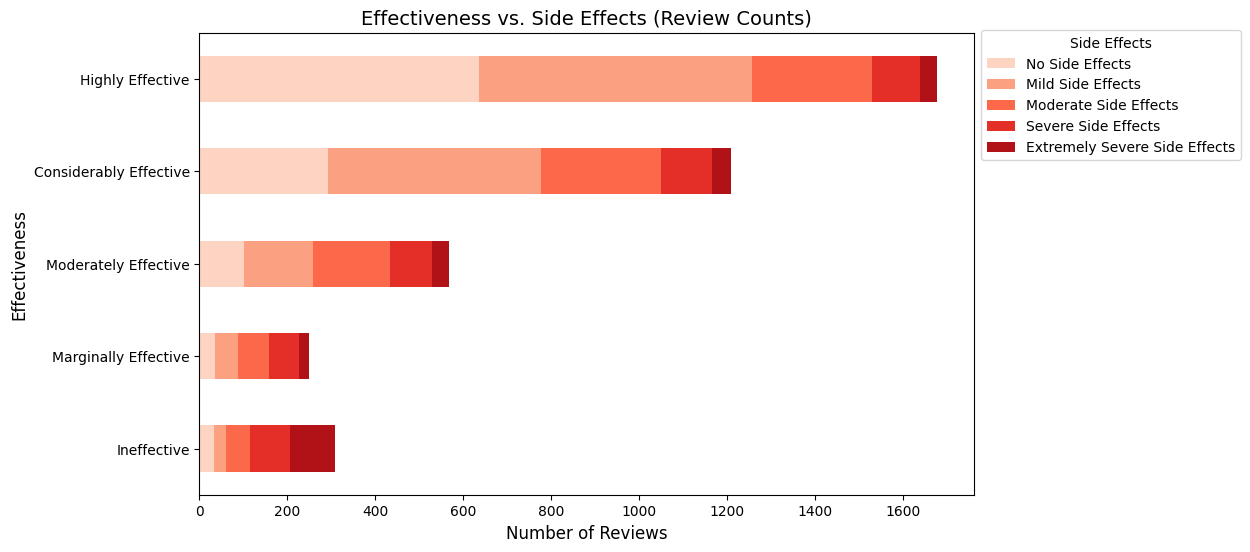

In [14]:
# Plotting horizontal bar chart to show drug's effectiveness and side effects distribution
effectiveness_order = [
    'Ineffective',
    'Marginally Effective',
    'Moderately Effective',
    'Considerably Effective',
    'Highly Effective'
]

sideEffects_order = [
    'No Side Effects',
    'Mild Side Effects',
    'Moderate Side Effects',
    'Severe Side Effects',
    'Extremely Severe Side Effects'
]

sideEffects_color = sns.color_palette("Reds", len(sideEffects_order))
data_bar1 = df_druglib.pivot_table(index='effectiveness',columns='sideEffects',values='commentsReview',aggfunc='count')
data_bar1 = data_bar1.reindex(index=effectiveness_order,columns=sideEffects_order)

ax = data_bar1.plot(kind='barh',stacked=True,color=sideEffects_color,figsize=(10, 6))

plt.title('Effectiveness vs. Side Effects (Review Counts)', fontsize=14)
plt.ylabel('Effectiveness', fontsize=12)
plt.xlabel('Number of Reviews', fontsize=12)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Side Effects', bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()

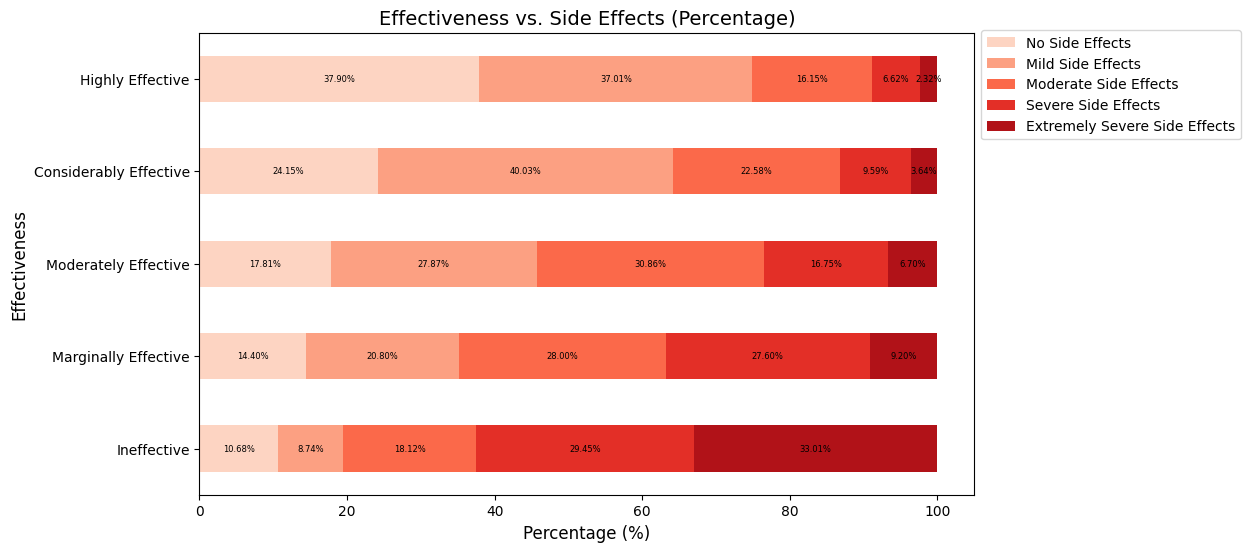

In [15]:
# Calculate row-wise sum for normalization
row_sums = data_bar1.sum(axis=1)

# Calculate percentages
data_percent = data_bar1.div(row_sums, axis=0) * 100

# Plotting
ax = data_percent.plot.barh(stacked=True,color=sideEffects_color,figsize=(10, 6))
plt.title('Effectiveness vs. Side Effects (Percentage)', fontsize=14)
plt.ylabel('Effectiveness', fontsize=12)
plt.xlabel('Percentage (%)', fontsize=12)

for c in ax.containers:

    # customize the label to account for cases when there might not be a bar section
    labels = [f'{w:.2f}%' if (w := v.get_width()) > 0 else '' for v in c ]

    # set the bar label
    ax.bar_label(c, labels=labels, label_type='center', fontsize=6)

ax.legend(bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()

The data shows that Side Effects of a drug tends to be severe if the Effectiveness of said drug increases and vice versa.

# Analysis Based on Drugs Condition and Name

In [16]:
conditions = df_druglib['condition'].unique()

print(len(conditions),' different conditions')
print('sample:')
for condition in conditions[:10]:
    print(condition)

1754  different conditions
sample:
management of congestive heart failure
birth prevention
menstrual cramps
acid reflux
fibromyalgia
hair loss
add
depression
panic disorder
allergies


In [17]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def split_text(text):
    return text.split(' ')

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stopwords and stem
    return ' '.join(words)

df_druglib['cleaned_reviews'] = df_druglib['commentsReview'].apply(preprocess_text)
df_druglib['cleaned_benefits'] = df_druglib['benefitsReview'].apply(preprocess_text)
df_druglib['cleaned_sideEffects'] = df_druglib['sideEffectsReview'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
keyword = 'acne'

filtered_df = df_druglib[df_druglib['condition'].str.contains(keyword)]

filtered_df.groupby('urlDrugName').agg(
    effectiveness=('effectiveness_rank', np.mean),
    sideEffects=('sideEffects_rank', np.mean),
    reviews=('commentsReview', 'count'),
    popularity=('rating', np.sum)
).sort_values(by='popularity', ascending=False)

/tmp/ipykernel_18/2667331981.py:5: FutureWarning: The provided callable <function mean at 0x7f1ac41fc4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  filtered_df.groupby('urlDrugName').agg(
/tmp/ipykernel_18/2667331981.py:5: FutureWarning: The provided callable <function mean at 0x7f1ac41fc4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  filtered_df.groupby('urlDrugName').agg(
/tmp/ipykernel_18/2667331981.py:5: FutureWarning: The provided callable <function sum at 0x7f1adc103520> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  filtered_df.groupby('urlDrugName').agg(


,effectiveness,sideEffects,reviews,popularity
urlDrugName,,,,
accutane,4.511628,2.860465,43,333
retin-a,3.966667,2.333333,30,231
differin,3.419355,2.064516,31,215
retin-a-micro,3.750000,2.500000,20,146
minocycline,3.222222,2.333333,18,101
spironolactone,4.333333,2.333333,12,98
tazorac,4.000000,2.615385,13,98
doxycycline,3.928571,2.785714,14,94
renova,3.727273,2.272727,11,88


In [19]:
drug = 'accutane'
df_drug = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]

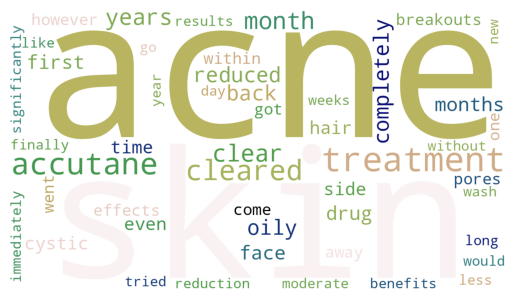

In [20]:
benefits = ' '.join(benefit for benefit in df_drug['cleaned_benefits'])
words = word_tokenize(benefits)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='gist_earth'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

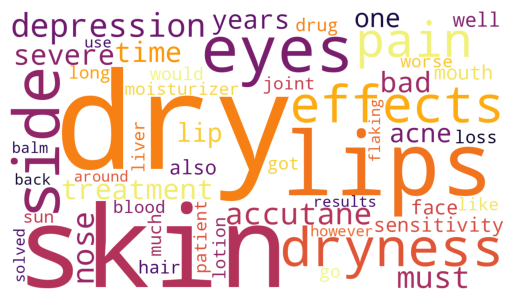

In [21]:
side_effects = ' '.join(side_effect for side_effect in df_drug['cleaned_sideEffects'])
words = word_tokenize(side_effects)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='inferno'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

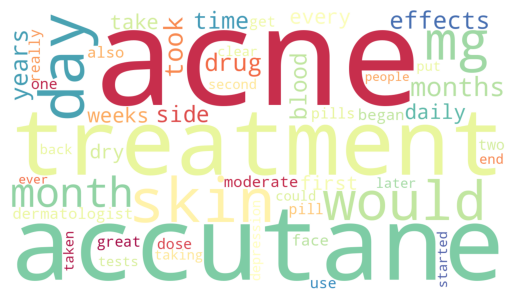

In [22]:
reviews = ' '.join(review for review in df_drug['cleaned_reviews'])
words = word_tokenize(reviews)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='Spectral'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def extract_top_n_words(text, n=5):
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Fit and transform the text
    tfidf_matrix = vectorizer.fit_transform([text])

    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Tokenize the original text to keep the context
    tokens = word_tokenize(text)

    # POS tagging for tokens in the context of the entire text
    tagged_tokens = pos_tag(tokens)

    # Extract feature names with their corresponding POS tags
    tagged_feature_names = pos_tag(feature_names)

    # Filter feature names to keep only adjectives and nouns
    filtered_feature_names = [word for word, pos in tagged_feature_names if ((pos.startswith('JJ') or pos.startswith('NN') or pos.startswith('RB')) and (not word.startswith(('effect','treatment','drug','medication'))))]

    # Get the TF-IDF scores for the filtered feature names
    filtered_tfidf_scores = {word: tfidf_matrix[0, vectorizer.vocabulary_[word]] for word in filtered_feature_names if word in vectorizer.vocabulary_}

    # Sort the filtered feature names by their TF-IDF scores in descending order
    sorted_filtered_words = sorted(filtered_tfidf_scores, key=filtered_tfidf_scores.get, reverse=True)

    # Return the top-n words
    return sorted_filtered_words[:n]

# Input text
text = ' '.join(side_effects for side_effects in df_drug['sideEffectsReview'])

# Get the top 5 significant words
top_words = extract_top_n_words(text, n=5)
print(top_words)

['dry', 'skin', 'lips', 'dryness', 'eyes']


# Add Side Effects Keywords to 5 Most Popular Drugs

In [24]:
keyword = 'acne'

filtered_df = df_druglib[df_druglib['condition'].str.contains(keyword)]

top5drugs = filtered_df.groupby('urlDrugName').agg(
    effectiveness=('effectiveness_rank', np.mean),
    sideEffects=('sideEffects_rank', np.mean),
    reviews=('commentsReview', 'count'),
    popularity=('rating', np.sum)
).sort_values(by='popularity', ascending=False).head(5)

/tmp/ipykernel_18/1310077520.py:5: FutureWarning: The provided callable <function mean at 0x7f1ac41fc4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  top5drugs = filtered_df.groupby('urlDrugName').agg(
/tmp/ipykernel_18/1310077520.py:5: FutureWarning: The provided callable <function mean at 0x7f1ac41fc4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  top5drugs = filtered_df.groupby('urlDrugName').agg(
/tmp/ipykernel_18/1310077520.py:5: FutureWarning: The provided callable <function sum at 0x7f1adc103520> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  top5drugs = filtered_df.groupby('urlDrugName').agg(


In [25]:
top5drugs

,effectiveness,sideEffects,reviews,popularity
urlDrugName,,,,
accutane,4.511628,2.860465,43,333
retin-a,3.966667,2.333333,30,231
differin,3.419355,2.064516,31,215
retin-a-micro,3.750000,2.500000,20,146
minocycline,3.222222,2.333333,18,101


In [26]:
map_side_effects = {}
for drug in top5drugs.index:
  df_temp = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]
  # Input text
  text_temp = ' '.join(side_effects for side_effects in df_temp['sideEffectsReview'])

  # Get the top 5 significant words
  top_words = extract_top_n_words(text_temp, n=5)
  map_side_effects.update({drug: top_words})

# Add new column to DataFrame
top5drugs['key_sideEffects'] = top5drugs.index.map(map_side_effects)

top5drugs

,effectiveness,sideEffects,reviews,popularity,key_sideEffects
urlDrugName,,,,,
accutane,4.511628,2.860465,43,333,"[dry, skin, lips, dryness, eyes]"
retin-a,3.966667,2.333333,30,231,"[skin, dry, redness, retin, dryness]"
differin,3.419355,2.064516,31,215,"[skin, dry, area, dryness, redness]"
retin-a-micro,3.750000,2.500000,20,146,"[skin, dry, retin, dryness, use]"
minocycline,3.222222,2.333333,18,101,"[skin, yeast, acne, infections, nystatin]"


In [27]:
keyword = 'depression'

filtered_df = df_druglib[df_druglib['condition'].str.contains(keyword)]

top5drugs = filtered_df.groupby('urlDrugName').agg(
    effectiveness=('effectiveness_rank', np.mean),
    sideEffects=('sideEffects_rank', np.mean),
    reviews=('commentsReview', 'count'),
    popularity=('rating', np.sum)
).sort_values(by='popularity', ascending=False).head(5)

map_side_effects = {}
for drug in top5drugs.index:
  df_temp = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]

  # Input text
  text_temp = ' '.join(side_effects for side_effects in df_temp['sideEffectsReview'])

  # Get the top 5 significant words
  top_words = extract_top_n_words(text_temp, n=5)
  map_side_effects.update({drug: top_words})

# Add new column to DataFrame
top5drugs['key_sideEffects'] = top5drugs.index.map(map_side_effects)

top5drugs

/tmp/ipykernel_18/1850082935.py:5: FutureWarning: The provided callable <function mean at 0x7f1ac41fc4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  top5drugs = filtered_df.groupby('urlDrugName').agg(
/tmp/ipykernel_18/1850082935.py:5: FutureWarning: The provided callable <function mean at 0x7f1ac41fc4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  top5drugs = filtered_df.groupby('urlDrugName').agg(
/tmp/ipykernel_18/1850082935.py:5: FutureWarning: The provided callable <function sum at 0x7f1adc103520> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  top5drugs = filtered_df.groupby('urlDrugName').agg(


,effectiveness,sideEffects,reviews,popularity,key_sideEffects
urlDrugName,,,,,
lexapro,3.661017,2.406780,59,403,"[lexapro, day, weight, gain, feel]"
prozac,4.157895,2.315789,38,288,"[libido, feel, loss, prozac, time]"
wellbutrin,3.702703,2.243243,37,269,"[mg, mouth, dry, tinnitus, wellbutrin]"
zoloft,3.971429,2.057143,35,257,"[libido, sex, nausea, sexual, day]"
effexor,3.631579,2.842105,38,248,"[felt, day, night, feeling, time]"


# Drugs Sentiment Analysis

In [28]:
drug = 'lexapro'
df_drug = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def sentiment_analyzer(df,text_column):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Define a function to apply sentiment analysis while handling NaN values
    def apply_sentiment_analysis(x):
        if isinstance(x, str):  # Check if x is a string
            return sid.polarity_scores(x)['compound']
        else:
            return float('nan')  # Return NaN for non-string values

    # Define threshold values for sentiment classification
    positive_threshold = 0.4
    negative_threshold = -0.4

    # Apply VADER sentiment analyzer
    df['sentiment_score'] = df[text_column].apply(apply_sentiment_analysis)

    # Apply sentiment labeling using lambda functions
    df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'Positive' if x > positive_threshold else ('Negative' if x < negative_threshold else 'Neutral'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [30]:
sentiment_analyzer(df_drug,'commentsReview')

/tmp/ipykernel_18/1805201346.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = df[text_column].apply(apply_sentiment_analysis)
/tmp/ipykernel_18/1805201346.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'Positive' if x > positive_threshold else ('Negative' if x < negative_threshold else 'Neutral'))


In [31]:
df_drug.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,effectiveness_rank,sideEffects_rank,cleaned_reviews,cleaned_benefits,cleaned_sideEffects,sentiment_score,sentiment_label
66,lexapro,6,Moderately Effective,Mild Side Effects,depression,"Before I started on the drug Lexapro, I felt l...",In the first week of treatment I felt disconne...,Lexapro was taken 2 times a day for 2 months.,3,2,lexapro taken times day months,started drug lexapro felt lethargic want get b...,first week treatment felt disconnected felt fu...,0.0000,Neutral
83,lexapro,5,Moderately Effective,Moderate Side Effects,depression and generalized anxiety,I sought treatment for two problems in my life...,"I gained 15 pounds, which my doctor swears was...",I missed an appointment with my doctor and was...,3,3,missed appointment doctor able get refill lexa...,sought treatment two problems life temper daug...,gained pounds doctor swears related medication...,-0.3911,Neutral
121,lexapro,9,Highly Effective,Mild Side Effects,major depression/anxiety,Before Lexapro I was so depressed I could not ...,I have some difficulty sleeping (waking up in ...,I have found that I have to take it at night ...,5,2,found take night sedating effect seems problem...,lexapro depressed could function forced work w...,difficulty sleeping waking night sometimes dia...,0.8170,Positive
198,lexapro,1,Moderately Effective,Severe Side Effects,depression,I felt less sadness.,i felt less of every emotion. i felt emotiona...,I took a whole 10 mg tablet the first time and...,3,4,took whole mg tablet first time right two days...,felt less sadness,felt less every emotion felt emotionally flat ...,0.0000,Neutral
205,lexapro,7,Considerably Effective,Moderate Side Effects,depression/anxiety,Lexapro worked very well to make me feel bette...,I gained ten pounds in the few months that I t...,I've taken several anti-depressants over the y...,4,3,taken several anti depressants years trying fi...,lexapro worked well make feel better less anxi...,gained ten pounds months took medicine,0.2732,Neutral


In [32]:
df_sentiment = df_drug.groupby('sentiment_label').agg(
    count=('sentiment_score', 'count'),
    avg_value=('sentiment_score', 'mean')
)

df_sentiment.rename(columns={'count': 'Total Reviews', 'avg_value': 'Avg. Sentiment Score'}, inplace=True)
df_sentiment.index.names = ['Sentiment Label']

# Define colors for each sentiment label
colors = {
    'Positive': '#00CC96',
    'Neutral': '#636EFA',
    'Negative': '#EF553B'
}

# Create a pie chart using Plotly Express
fig = px.pie(
    df_sentiment.reset_index(),
    names='Sentiment Label',
    values='Total Reviews',
    color='Sentiment Label',
    width=600,
    height=600,
    color_discrete_map=colors
)

fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent'
)
fig.update_layout(
    title_text=f'{drug.capitalize()} Sentiment Analysis',
    title_x=0.5,
    title_font_size=30)
